<a href="https://colab.research.google.com/github/u25723007/COS802_Mini_Project/blob/main/Sesotho_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Prepare by Tankiso Kolobe for COS802 Project

**Investigating Sentiment Analysis for Sesotho, a low-recourse African language**

In [ ]:
# Package installation and imports - run this first
import importlib.util, sys, subprocess
packages = [ 'evaluate', 'transformers',]
for package_name in packages:
    is_present = importlib.util.find_spec(package_name)
    if is_present is None:
        print(f"{package_name} is not installed")
        !pip install {package_name}
        print(f"{package_name} is now installed")
    else:
        print(f"{package_name} is installed")

evaluate is not installed
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.8 MB/s eta 0:00:00
evaluate is now installed
transformers is installed


In [ ]:
!pip install googletrans==3.1.0a0

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 85.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 6.1 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-3.1.0a0-py3-none-any.whl size=16353 sha256=eec9b834c6c61eaa7a06dc3775984b3180e9630b4f4599f75637261421dada24
  Stored in directory: /root/.cache/pip/wheels/96/ac/bd/9df9eab356c0576896e97147425987f6f45e9e46456c978d18
Successfully built googletrans
  Attempting uninstall: hyperframe
    Found existing installation: hyperframe 6.1.0
    Uninstalling hyperfram

In [ ]:
import pandas as pd
import re
from googletrans import Translator
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from datasets import load_dataset, concatenate_datasets, Dataset
from transformers import AutoTokenizer, AutoModelForMaskedLM, AutoModelForSequenceClassification, Trainer, TrainingArguments, AutoModel
import evaluate
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import torch
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import torch.nn as nn
from sklearn.model_selection import train_test_split

Import and View Data

In [ ]:
#use this line if running from local machine
file_path = "NewsSA.txt"

In [ ]:
#use thisle line if running on Colab
file_path = "/content/drive/MyDrive/NewsSA.txt"

In [ ]:


# Read file and clean
with open(file_path, "r", encoding="utf-8") as f:
    lines = [line.strip() for line in f if line.strip()]

headlines = lines[::2]
labels = lines[1::2]

# Filter valid numeric labels
valid_data = [(h, l) for h, l in zip(headlines, labels) if l in ["-1", "0", "1"]]

# Create DataFrame
df = pd.DataFrame(valid_data, columns=["headline", "label"])
df["label"] = df["label"].astype(int)

# Map numeric labels to sentiment names
label_map = {-1: "Negative", 0: "Neutral", 1: "Positive"}
df["sentiment"] = df["label"].map(label_map)

# Count sentiment distribution
label_counts = df["sentiment"].value_counts().reset_index()
label_counts.columns = ["Sentiment", "Count"]


# Calculate percentages
total = label_counts["Count"].sum()
label_counts["Percentage"] = (label_counts["Count"] / total * 100).round(0)

label_counts["LabelText"] = label_counts.apply(lambda row: f"<b>{row['Count']} ({row['Percentage']}%)</b>", axis=1)

# Create bar graph and percentage labels
fig = px.bar(label_counts, x="Sentiment", y="Count",
             title="Distribution of Headlines Per Sentiment Class",
             labels={"Sentiment": "Sentiment Label", "Count": "Number of Headlines"},
             text="LabelText")
fig.update_traces(textposition="outside")
fig.update_layout(width=450, height=500)
fig.show()



Data split

In [ ]:

with open(file_path, "r", encoding="utf-8") as f:
    lines = [line.strip() for line in f if line.strip()]

# Separate headlines and labels
headlines = lines[::2]
labels = lines[1::2]

# Filter valid numeric labels
valid_data = [(h, l) for h, l in zip(headlines, labels) if l in ["-1", "0", "1"]]

# Create DataFrame
df = pd.DataFrame(valid_data, columns=["headline", "label"])
df["label"] = df["label"].astype(int)

# Split into train (70%), temp (30%)
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df["label"])

# Split temp into validation (15%) and test (15%)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df["label"])


In [ ]:
# View dataframe
val_df.head()

,headline,label
712,KOLOI E ILENG EA UTSUOA KEREKENG E FUMANOA NAH...,1
462,MAPOLESA A BOLAILE LINOKOANE TSE 18,-1
360,SETSI SE KOALA SEEA-LE-MOEA,-1
1130,NGOANA ESALE A BETOA HO TLOHA SELEMO SE FETILENG,-1
66,LETONA LE TLA ARABA TSA LEFU LA MOSEBETSI KAJENO,-1


In [ ]:
#Convert DataFrames to Hugging Face Datasets
train_sesotho_news_dataset = Dataset.from_pandas(train_df).remove_columns("__index_level_0__")
validation_sesotho_news_dataset = Dataset.from_pandas(val_df).remove_columns("__index_level_0__")
test_sesotho_news_dataset = Dataset.from_pandas(test_df).remove_columns("__index_level_0__")

#print features and examples
print(train_sesotho_news_dataset.features)
print(train_sesotho_news_dataset[0])

{'headline': Value('string'), 'label': Value('int64')}
{'headline': 'SEPOLESA SE QABETSOE', 'label': -1}


In [ ]:

# Extract unique labels
labels = train_sesotho_news_dataset.unique("label")
label2id = {label: i for i, label in enumerate(labels)}
id2label = {i: label for label, i in label2id.items()}

def encode_labels(example):
    example["label"] = label2id[example["label"]]
    return example

train_sesotho_news_dataset = train_sesotho_news_dataset.map(encode_labels)
validation_sesotho_news_dataset = validation_sesotho_news_dataset.map(encode_labels)
test_sesotho_news_dataset = test_sesotho_news_dataset.map(encode_labels)

Map:   0%|          | 0/1546 [00:00<?, ? examples/s]

Map:   0%|          | 0/331 [00:00<?, ? examples/s]

Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Part A:

monolingual analysis with Afro-XLM-R

In [ ]:
#use afro-xlm-r model from huggingface
model_name_A = AutoModelForMaskedLM.from_pretrained("Davlan/afro-xlmr-small")
tokenizer_A = AutoTokenizer.from_pretrained("Davlan/afro-xlmr-small")
embedding_model_A = AutoModel.from_pretrained("Davlan/afro-xlmr-small")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



config.json:   0%|          | 0.00/757 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/561M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/536 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

Some weights of XLMRobertaModel were not initialized from the model checkpoint at Davlan/afro-xlmr-small and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def get_embeddings_A(texts):
    inputs = tokenizer_A(texts, padding=True, truncation=True, return_tensors="pt", max_length=256)
    with torch.no_grad():
        outputs = embedding_model_A(**inputs)
    return outputs.last_hidden_state[:, 0, :].cpu().numpy()  # CLS token embeddings

In [ ]:
X_train = get_embeddings_A(list(train_sesotho_news_dataset["headline"]))
y_train = np.array(train_sesotho_news_dataset["label"])


In [ ]:
# Apply SMOTE to ovesample minority class
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", np.bincount(y_train))
print("After SMOTE:", np.bincount(y_resampled))


Before SMOTE: [1086  386   74]
After SMOTE: [1086 1086 1086]


In [ ]:

# 5. Convert back to Hugging Face Dataset
resampled_texts = [train_sesotho_news_dataset["headline"][i % len(train_sesotho_news_dataset)] for i in range(len(X_resampled))]
resampled_dataset = Dataset.from_dict({"headline": resampled_texts, "label": y_resampled})

In [ ]:
def tokenize_A(batch):
    return tokenizer_A(batch["headline"], padding="max_length", truncation=True)

train_sesotho_news_dataset = resampled_dataset.map(tokenize_A, batched=True)
validation_sesotho_news_dataset = validation_sesotho_news_dataset.map(tokenize_A, batched=True)
test_sesotho_news_dataset = test_sesotho_news_dataset.map(tokenize_A, batched=True)

train_sesotho_news_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
validation_sesotho_news_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_sesotho_news_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

Map:   0%|          | 0/3258 [00:00<?, ? examples/s]

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/331 [00:00<?, ? examples/s]

Map:   0%|          | 0/332 [00:00<?, ? examples/s]

In [ ]:
# Compute Class Weights
class_weights = compute_class_weight(class_weight="balanced",
                                     classes=np.array(range(len(labels))),
                                     y=y_resampled)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

In [ ]:
#define model
model_A = AutoModelForSequenceClassification.from_pretrained(
    "Davlan/afro-xlmr-small",
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id
)


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at Davlan/afro-xlmr-small and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Metrics to be used for evaluation
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    return {
        "accuracy": accuracy.compute(predictions=predictions, references=labels)["accuracy"],
        "f1": f1.compute(predictions=predictions, references=labels, average="weighted")["f1"]
    }


In [ ]:
#use the computed class weitghs to balance class during trainning
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = nn.CrossEntropyLoss(weight=class_weights_tensor.to(model.device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss


In [ ]:

#  Training Setup
training_args_A = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    weight_decay=0.01,
    warmup_ratio=0.1,
    logging_dir="./logs",
    logging_steps=100,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True

)

trainer_A = WeightedTrainer(
    model=model_A,
    args=training_args_A,
    train_dataset=train_sesotho_news_dataset,
    eval_dataset=validation_sesotho_news_dataset,
    tokenizer=tokenizer_A,
    compute_metrics=compute_metrics
)


/tmp/ipython-input-2152821033.py:21: FutureWarning:

`tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.



In [ ]:
# Train afro-xlm-r model
trainer_A.train()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning:

invalid escape sequence '\/'

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: u25723007 (u25723007-university-of-pretoria) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.098800,1.047251,0.580060,0.595195
2,1.093500,1.120406,0.096677,0.095105
3,1.088200,1.066299,0.564955,0.610653
4,1.081200,0.999737,0.664653,0.680949
5,1.063700,1.066648,0.540785,0.574854
6,1.055500,0.988589,0.643505,0.681674
7,1.045900,0.965476,0.664653,0.687284
8,1.032100,1.039281,0.577039,0.628765
9,1.026800,0.999381,0.628399,0.661972
10,1.018800,0.976618,0.661631,0.688899


TrainOutput(global_step=1020, training_loss=1.0597604321498497, metrics={'train_runtime': 501.4991, 'train_samples_per_second': 64.965, 'train_steps_per_second': 2.034, 'total_flos': 769713636680352.0, 'train_loss': 1.0597604321498497, 'epoch': 10.0})

In [ ]:
# 8. Evaluate and predict results
results = trainer_A.evaluate()
print(results)


{'eval_loss': 0.9766181707382202, 'eval_accuracy': 0.6616314199395771, 'eval_f1': 0.6888992698004839, 'eval_runtime': 0.957, 'eval_samples_per_second': 345.874, 'eval_steps_per_second': 11.494, 'epoch': 10.0}


In [ ]:
# Get predictions from Trainer
predictions = trainer_A.predict(test_sesotho_news_dataset)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)


label_map = {-1: "Negative", 0: "Neutral", 1: "Positive"}
target_names = [label_map[i] for i in sorted(label_map.keys())]
print("Afro-XLM-R Prediction Results")
print(classification_report(y_true, y_pred, target_names=target_names))

In [ ]:

report_A = classification_report(y_true, y_pred, output_dict=True)

# Access metrics dynamically
accuracy_A = round(report_A['accuracy'], 2)
macro_f1_A = round(report_A['macro avg']['f1-score'],2)
Precision_A = round(report_A['macro avg']['precision'], 2)
Recall_A = round(report_A['macro avg']['recall'],2)

print("Accuracy:", accuracy_A)
print("Macro F1:", macro_f1_A)
print("Precision:", Precision_A)
print("Recall:", Recall_A)

Accuracy: 0.71
Macro F1: 0.57
Precision: 0.55
Recall: 0.63


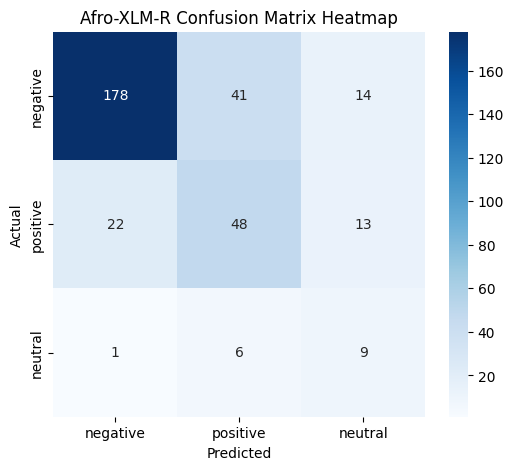

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
labels = ["negative", "positive", "neutral"]

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Afro-XLM-R Confusion Matrix Heatmap")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
# Generate classification report
report = classification_report(y_true, y_pred, target_names=labels, output_dict=True)

# Extract F1 scores dynamically
f1_scores = [report[label]['f1-score'] for label in labels]

# Plot F1 scores
fig = px.bar(x=labels, y=f1_scores, labels={'x':'Class', 'y':'F1 Score'}, title="Afro-XLM-R Per-Class F1 Scores", text=f1_scores)
fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig.update_layout(width=400, height=500)
fig.show()

**Part B**

Cross-lingual transfer learning with BERT-Base-uncased

B.1 Translation from Sesotho to Englisg with Google Translate

In [ ]:
translator = Translator()

In [ ]:
# Translation test
translation = translator.translate('LEPOLESA LE TORONKELA HO BOLAEA MOTHO', src='st', dest='en')
print(translation.text)


A POLICEMAN IS IN PRISON FOR MURDERING A PERSON


In [ ]:


# Read and clean lines
with open(file_path, "r", encoding="utf-8") as f:
    lines = [line.strip() for line in f if line.strip()]

# Separate headlines and labels
headlines = lines[::2]
labels = lines[1::2]

# Filter valid numeric labels
valid_data = [(h, l) for h, l in zip(headlines, labels) if l in ["-1", "0", "1"]]

# Create DataFrame
df = pd.DataFrame(valid_data, columns=["headline", "label"])
df["label"] = df["label"].astype(int)

# Split into train (70%), temp (30%)
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df["label"])

# Split temp into validation (15%) and test (15%)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df["label"])

In [ ]:
#Convert DataFrames to Hugging Face Datasets
train_sesotho_news_dataset = Dataset.from_pandas(train_df).remove_columns("__index_level_0__")
validation_sesotho_news_dataset = Dataset.from_pandas(val_df).remove_columns("__index_level_0__")
test_sesotho_news_dataset = Dataset.from_pandas(test_df).remove_columns("__index_level_0__")


In [ ]:
# Convert datasets to lists
train_headlines = train_sesotho_news_dataset["headline"]
train_labels = train_sesotho_news_dataset["label"]

validation_headlines = validation_sesotho_news_dataset["headline"]
validation_labels = validation_sesotho_news_dataset["label"]

test_headlines = test_sesotho_news_dataset["headline"]
test_labels = test_sesotho_news_dataset["label"]

In [ ]:

# Translate headlines
translated_train = []
for text in train_headlines:
    try:
        translated_train.append(translator.translate(text, src='st', dest='en').text)
    except Exception as e:
        translated_train.append("TRANSLATION_FAILED")

translated_validation = []
for text in validation_headlines:
    try:
        translated_validation.append(translator.translate(text, src='st', dest='en').text)
    except Exception as e:
        translated_validation.append("TRANSLATION_FAILED")

translated_test = []
for text in test_headlines:
    try:
        translated_test.append(translator.translate(text, src='st', dest='en').text)
    except Exception as e:
        translated_test.append("TRANSLATION_FAILED")

In [ ]:
# Create DataFrames
train_df = pd.DataFrame({"text": translated_train, "label": train_labels})
validation_df = pd.DataFrame({"text": translated_validation, "label": validation_labels})
test_df = pd.DataFrame({"text": translated_test, "label": test_labels})

# Save to CSV
#train_df.to_csv("english_train_dataset.csv", index=False)
#validation_df.to_csv("english_validation_dataset.csv", index=False)
#test_df.to_csv("english_test_dataset.csv", index=False)

print("Sample translated train data:\n", train_df.head())
print("Sample translated train data:\n", validation_df.head())
print("Sample translated test data:\n", test_df.head())


Sample translated train data:
                                                 text  label
0                                     POLICE OFFICER     -1
1               A CHURCH PRIEST IS KILLED BY BURNING     -1
2  THE SNOW IS VERY PACKED AVOIDING MOUNTAIN TRIP...     -1
3  THE GIRL WHO LAST WAS GIVEN A LETTER BY THE DE...     -1
4  WORLD HEALTH ASSOCIATION CELEBRATES WITH POLIC...      1
Sample translated train data:
                                                 text  label
0  THE CAR THAT WAS STOLEN FROM THE CHURCH WAS FO...      1
1                         POLICE KILLED 18 CRIMINALS     -1
2                     THE CENTER SHUTS OFF THE RADIO     -1
3           THE CHILD HAS BEEN RAPED SINCE LAST YEAR     -1
4  THE MINISTER WILL ANSWER ABOUT OCCUPATIONAL DE...     -1
Sample translated test data:
                                                 text  label
0                         THE MAN DRINKS IN THE POOL     -1
1                            WOMAN WANTED FOR MURDER     -1
2     RE

In [ ]:
train_df = train_df[train_df["text"] != "TRANSLATION_FAILED"]
validation_df = validation_df[validation_df["text"] != "TRANSLATION_FAILED"]
test_df = test_df[test_df["text"] != "TRANSLATION_FAILED"]


# Save cleaned DataFrames to file
train_path = "english_train_dataset.csv"
validation_path = "english_validation_dataset.csv"
test_path = "english_test_dataset.csv"

train_df.to_csv(train_path, index=False)
validation_df.to_csv(validation_path, index=False)
test_df.to_csv(test_path, index=False)


In [ ]:
# Original Sesotho sentences
sesotho_sentences = [
    "RASETHUNYA O QETA SECHABA MAPOLESA A SHEBELETSE", "BASUOE BA QOSUOE KA PELAELO EA HO BOLAEA MOSHEMANE LEBOLLONG", "SEHLOPHA SA BOLO SE BOELA E NGOLA NALANE E MPE",
    "MOKHATLO O RERA LIKETANE TSA LITŠEBETSO", "NGOANANA O SHEMOLA NTATAE SEPHAKA", "TONAKHOLO O TLO ABELA SECHABA LIJO-THOLLO","LEKHOTLA LE THIBELA HO LIHELOA HA TONAKHOLO",
    "LEKHOTLA LE TSOELA PELE HO HLALOSA MAANO", "MOFU O SHAPILE MOSALI OA MOTHO HA A TLA BOLAOA", "TONAKHOLO O PHELISA SECHABA KA LESHANO"
]

# Human reference translation
human_references = [
    "A GUNMAN TERRORIZED THE NATION, WHILE POLICE WATCHED", "INSTRUCTORS CHARGED ON SUSPECT OF KILLING A BOY IN INITIATION SCHOOL", "FOOTBALL TEAM AGAIN WRITES A BAD HISTORY",
"SOCIETY PLANS CHAINS OF LABOR", "GIRL KICKS HER FATHER'S EYE", "PRIME MINISTER TO DISTRIBUTE FOOD TO THE NATION", "COURT PREVENTS THE DOWNPUT OF THE PRIME MINISTER",
"COURT CONTINUES TO EXPLAIN POLICIES", "DEAD MAN HIT A MAN'S WIFE FOR HIM TO BE KILLED", "PRIME MINISTER IS LYING TO THE NATION"
]

machine_translations= [translator.translate(text, src='st', dest='en').text for text in sesotho_sentences]
print(machine_translations)

['THE GUN KILLS THE COMMUNITY AS THE POLICE WATCH', 'SUESUE HAS BEEN ACCUSED ON SUSPECT OF KILLING A BOY IN A BALL', 'THE FOOTBALL TEAM IS WRITING A BAD HISTORY AGAIN', 'ORGANIZATION PLANNING SUPPLY CHAIN', 'A GIRL PUSHES HER FATHER', 'THE PRIME MINISTER WILL DISTRIBUTE FOOD TO THE PEOPLE', 'COURT PREVENTS THE OVERCOME OF THE PRIME MINISTER', 'THE COURT CONTINUES TO EXPLAIN POLICY', "THE DEAD BEAT MAN'S WIFE WHEN HE WAS NOT GOING TO BE KILLED", 'THE PRIME MINISTER IS BUILDING THE PEOPLE WITH LIES']


In [ ]:
smoothie = SmoothingFunction().method1

# Prepare references as tokenized lists
reference_sentences = [[ref.split()] for ref in human_references]
translated_sentences = [trans.split() for trans in machine_translations]

# Compute BLEU scores
bleu_scores = [
    sentence_bleu(ref, trans, smoothing_function=smoothie)
    for ref, trans in zip(reference_sentences, translated_sentences)
]

average_bleu = sum(bleu_scores) / len(bleu_scores)

print("BLEU scores per sentence:", bleu_scores)
print("Average BLEU score:", average_bleu)

BLEU scores per sentence: [0.028517539529041507, 0.4703709593866897, 0.1561969968460128, 0, 0.06389431042462725, 0.3549481056010053, 0.5, 0.5081327481546147, 0.10120193244194395, 0.12753431387594827]
Average BLEU score: 0.23107969062598835


B.2 Traning and evaluation of BERT-base-uncased using the translated headlines

In [ ]:

# Load dataset
dataset = load_dataset("csv", data_files={"train": 'english_train_dataset.csv', "validation": "english_validation_dataset.csv", "test": "english_test_dataset.csv"})



Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
# Extract unique labels
labels = dataset["train"].unique("label")
label2id = {label: i for i, label in enumerate(labels)}
id2label = {i: label for label, i in label2id.items()}

def encode_labels(example):
    example["label"] = label2id[example["label"]]
    return example

train_dataset = dataset["train"].map(encode_labels)
validation_dataset = dataset["validation"].map(encode_labels)
test_dataset = dataset["test"].map(encode_labels)

Map:   0%|          | 0/1546 [00:00<?, ? examples/s]

Map:   0%|          | 0/331 [00:00<?, ? examples/s]

Map:   0%|          | 0/332 [00:00<?, ? examples/s]

In [ ]:
#load BERT-base-uncaed model from huggingface
model_name_B = AutoModelForMaskedLM.from_pretrained("bert-base-uncased")
tokenizer_B = AutoTokenizer.from_pretrained("bert-base-uncased")
embedding_model_B = AutoModel.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
def get_embeddings_B(texts):
    inputs = tokenizer_B(texts, padding=True, truncation=True, return_tensors="pt", max_length=256)
    with torch.no_grad():
        outputs = embedding_model_B(**inputs)
    return outputs.last_hidden_state[:, 0, :].cpu().numpy()

In [ ]:
X_train = get_embeddings_B(list(train_dataset["text"]))
y_train = np.array(train_dataset["label"])

In [ ]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", np.bincount(y_train))
print("After SMOTE:", np.bincount(y_resampled))


Before SMOTE: [1086  386   74]
After SMOTE: [1086 1086 1086]


In [ ]:
# Convert back to Hugging Face Dataset
resampled_texts = [train_dataset["text"][i % len(train_dataset)] for i in range(len(X_resampled))]
resampled_dataset = Dataset.from_dict({"text": resampled_texts, "label": y_resampled})

In [ ]:
# Tokenize

def tokenize_B(batch):
    return tokenizer_B(batch["text"], padding="max_length", truncation=True, max_length=256)

train_dataset = train_dataset.map(tokenize_B, batched=True)
validation_dataset = validation_dataset.map(tokenize_B, batched=True)
test_dataset = test_dataset.map(tokenize_B, batched=True)

train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
validation_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

Map:   0%|          | 0/1546 [00:00<?, ? examples/s]

Map:   0%|          | 0/331 [00:00<?, ? examples/s]

Map:   0%|          | 0/332 [00:00<?, ? examples/s]

In [ ]:
# Model

model_B = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# 5. Metrics
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    return {
        "accuracy": accuracy.compute(predictions=predictions, references=labels)["accuracy"],
        "f1": f1.compute(predictions=predictions, references=labels, average="weighted")["f1"]
    }

In [ ]:
# BERT Training Setup
training_args_B = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-4,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    warmup_ratio=0.1,
    logging_dir="./logs",
    logging_steps=100,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True
)

In [ ]:

# Trainer
trainer_B = Trainer(
    model=model_B,
    args=training_args_B,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    tokenizer=tokenizer_B,
    compute_metrics=compute_metrics
)

/tmp/ipython-input-27412253.py:2: FutureWarning:

`tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.



In [ ]:
trainer_B.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.560583,0.779456,0.752896
2,No log,0.556143,0.788520,0.775841
3,0.573000,0.754646,0.779456,0.767571


TrainOutput(global_step=147, training_loss=0.448159561676233, metrics={'train_runtime': 241.5383, 'train_samples_per_second': 19.202, 'train_steps_per_second': 0.609, 'total_flos': 610160015711232.0, 'train_loss': 0.448159561676233, 'epoch': 3.0})

In [ ]:
#Evaluate
results = trainer_B.evaluate()
print(results)

{'eval_loss': 0.5561425685882568, 'eval_accuracy': 0.7885196374622356, 'eval_f1': 0.7758405349453437, 'eval_runtime': 5.0145, 'eval_samples_per_second': 66.009, 'eval_steps_per_second': 2.194, 'epoch': 3.0}


In [ ]:
# Predictions
predictions = trainer_B.predict(test_dataset)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)


label_map = {-1: "Negative", 0: "Neutral", 1: "Positive"}
target_names = [label_map[i] for i in sorted(label_map.keys())]

print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    Negative       0.87      0.92      0.90       233
     Neutral       0.75      0.60      0.67        83
    Positive       0.61      0.69      0.65        16

    accuracy                           0.83       332
   macro avg       0.74      0.74      0.74       332
weighted avg       0.83      0.83      0.83       332



In [ ]:

report_B = classification_report(y_true, y_pred, output_dict=True)

# Access metrics dynamically
accuracy_B = round(report_B['accuracy'], 2)
macro_f1_B = round(report_B['macro avg']['f1-score'],2)
Precision_B = round(report_B['macro avg']['precision'], 2)
Recall_B = round(report_B['macro avg']['recall'],2)

print("Accuracy:", accuracy_B)
print("Macro F1:", macro_f1_B)
print("Precision:", Precision_B)
print("Recall:", Recall_B)

Accuracy: 0.83
Macro F1: 0.74
Precision: 0.74
Recall: 0.74


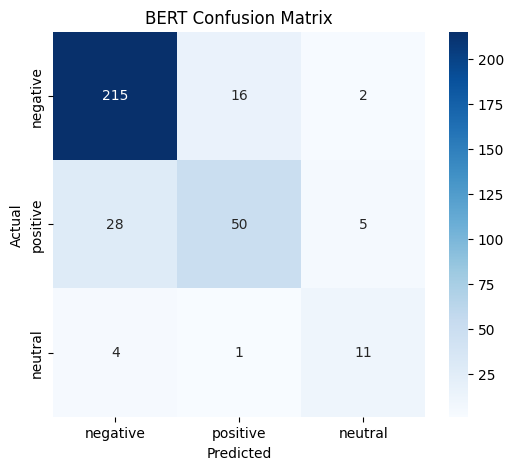

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
labels = ["negative", "positive", "neutral"]

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("BERT Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
# Generate classification report
report = classification_report(y_true, y_pred, target_names=labels, output_dict=True)

# Extract F1 scores dynamically
f1_scores = [report[label]['f1-score'] for label in labels]

# Plot F1 scores
fig = px.bar(x=labels, y=f1_scores, labels={'x':'Class', 'y':'F1 Score'}, title="BERT Per-Class F1 Scores", text=f1_scores)
fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig.update_layout(width=400, height=500)
fig.show()

**PART P**

PuoBERTa traning and evaluation

In [ ]:
# Read and clean lines
with open(file_path, "r", encoding="utf-8") as f:
    lines = [line.strip() for line in f if line.strip()]

# Separate headlines and labels
headlines = lines[::2]
labels = lines[1::2]

# Filter valid numeric labels
valid_data = [(h, l) for h, l in zip(headlines, labels) if l in ["-1", "0", "1"]]

# Create DataFrame
df = pd.DataFrame(valid_data, columns=["headline", "label"])
df["label"] = df["label"].astype(int)

# Split into train (70%), temp (30%)
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df["label"])

# Split temp into validation (15%) and test (15%)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df["label"])

In [ ]:
#Convert DataFrames to Hugging Face Datasets
train_sesotho_news_dataset = Dataset.from_pandas(train_df).remove_columns("__index_level_0__")
validation_sesotho_news_dataset = Dataset.from_pandas(val_df).remove_columns("__index_level_0__")
test_sesotho_news_dataset = Dataset.from_pandas(test_df).remove_columns("__index_level_0__")

In [ ]:
# Extract unique labels
labels = train_sesotho_news_dataset.unique("label")
label2id = {label: i for i, label in enumerate(labels)}
id2label = {i: label for label, i in label2id.items()}

def encode_labels(example):
    example["label"] = label2id[example["label"]]
    return example

train_sesotho_news_dataset = train_sesotho_news_dataset.map(encode_labels)
validation_sesotho_news_dataset = validation_sesotho_news_dataset.map(encode_labels)
test_sesotho_news_dataset = test_sesotho_news_dataset.map(encode_labels)

Map:   0%|          | 0/1546 [00:00<?, ? examples/s]

Map:   0%|          | 0/331 [00:00<?, ? examples/s]

Map:   0%|          | 0/332 [00:00<?, ? examples/s]

In [ ]:
model_name_P = AutoModelForMaskedLM.from_pretrained("DSFSI/puoberta")
tokenizer_P = AutoTokenizer.from_pretrained("DSFSI/puoberta")
embedding_model_P = AutoModel.from_pretrained("DSFSI/puoberta")

Some weights of RobertaModel were not initialized from the model checkpoint at DSFSI/puoberta and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def get_embeddings_P(texts):
    inputs = tokenizer_P(texts, padding=True, truncation=True, return_tensors="pt", max_length=256)
    with torch.no_grad():
        outputs = embedding_model_P(**inputs)
    return outputs.last_hidden_state[:, 0, :].cpu().numpy()  # CLS token embeddings

In [ ]:
X_train = get_embeddings_P(list(train_sesotho_news_dataset["headline"]))
y_train = np.array(train_sesotho_news_dataset["label"])

In [ ]:
#  Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", np.bincount(y_train))
print("After SMOTE:", np.bincount(y_resampled))

Before SMOTE: [1086  386   74]
After SMOTE: [1086 1086 1086]


In [ ]:
# Convert back to Hugging Face Dataset
resampled_texts = [train_sesotho_news_dataset["headline"][i % len(train_sesotho_news_dataset)] for i in range(len(X_resampled))]
resampled_dataset = Dataset.from_dict({"headline": resampled_texts, "label": y_resampled})

In [ ]:
def tokenize_P(batch):
    return tokenizer_P(batch["headline"], padding="max_length", truncation=True)

train_sesotho_news_dataset = resampled_dataset.map(tokenize_P, batched=True)
validation_sesotho_news_dataset = validation_sesotho_news_dataset.map(tokenize_P, batched=True)
test_sesotho_news_dataset = test_sesotho_news_dataset.map(tokenize_P, batched=True)

train_sesotho_news_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
validation_sesotho_news_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_sesotho_news_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

Map:   0%|          | 0/3258 [00:00<?, ? examples/s]

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/331 [00:00<?, ? examples/s]

Map:   0%|          | 0/332 [00:00<?, ? examples/s]

In [ ]:
# Compute Class Weights
class_weights = compute_class_weight(class_weight="balanced",
                                     classes=np.array(range(len(labels))),
                                     y=y_resampled)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

In [ ]:

model_P = AutoModelForSequenceClassification.from_pretrained(
    "DSFSI/puoberta",
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id
)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DSFSI/puoberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:

#  Metrics
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    return {
        "accuracy": accuracy.compute(predictions=predictions, references=labels)["accuracy"],
        "f1": f1.compute(predictions=predictions, references=labels, average="weighted")["f1"]
    }


In [ ]:


class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = nn.CrossEntropyLoss(weight=class_weights_tensor.to(model.device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss


In [ ]:

# Training Setup
training_args_P = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    weight_decay=0.01,
    warmup_ratio=0.1,
    logging_dir="./logs",
    logging_steps=100,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True

)

trainer_P = WeightedTrainer(
    model=model_P,
    args=training_args_P,
    train_dataset=train_sesotho_news_dataset,
    eval_dataset=validation_sesotho_news_dataset,
    tokenizer=tokenizer_P,
    compute_metrics=compute_metrics
)


/tmp/ipython-input-1199601245.py:21: FutureWarning:

`tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.



In [ ]:
trainer_P.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.115600,1.110010,0.117825,0.129375
2,1.098600,1.191238,0.151057,0.153270
3,1.077200,1.104227,0.413897,0.432279
4,1.057300,0.984606,0.586103,0.607400
5,1.030900,1.088782,0.438066,0.486924
6,1.021500,1.018846,0.498489,0.555121
7,0.984700,0.999412,0.522659,0.572934
8,0.963300,1.024235,0.495468,0.541842
9,0.950100,0.998017,0.552870,0.591136
10,0.933500,1.005578,0.528701,0.576284


TrainOutput(global_step=1020, training_loss=1.0216311735265395, metrics={'train_runtime': 205.6019, 'train_samples_per_second': 158.462, 'train_steps_per_second': 4.961, 'total_flos': 310999154464044.0, 'train_loss': 1.0216311735265395, 'epoch': 10.0})

In [ ]:
# Evaluate
results = trainer_P.evaluate()
print(results)

{'eval_loss': 0.9846056699752808, 'eval_accuracy': 0.5861027190332326, 'eval_f1': 0.6073996025130026, 'eval_runtime': 0.481, 'eval_samples_per_second': 688.204, 'eval_steps_per_second': 22.871, 'epoch': 10.0}


In [ ]:
# Predictions
predictions = trainer_P.predict(test_sesotho_news_dataset)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)


label_map = {-1: "Negative", 0: "Neutral", 1: "Positive"}
target_names = [label_map[i] for i in sorted(label_map.keys())]

print("PuoBERTa Results")
print(classification_report(y_true, y_pred, target_names=target_names))

PuoBERTa Results
              precision    recall  f1-score   support

    Negative       0.87      0.67      0.75       233
     Neutral       0.43      0.72      0.54        83
    Positive       0.14      0.12      0.13        16

    accuracy                           0.65       332
   macro avg       0.48      0.50      0.48       332
weighted avg       0.72      0.65      0.67       332



In [ ]:

report_P = classification_report(y_true, y_pred, output_dict=True)

# Access metrics dynamically
accuracy_P = round(report_P['accuracy'], 2)
macro_f1_P = round(report_P['macro avg']['f1-score'],2)
Precision_P = round(report_P['macro avg']['precision'], 2)
Recall_P = round(report_P['macro avg']['recall'],2)

print("Accuracy:", accuracy_P)
print("Macro F1:", macro_f1_P)
print("Precision:", Precision_P)
print("Recall:", Recall_P)


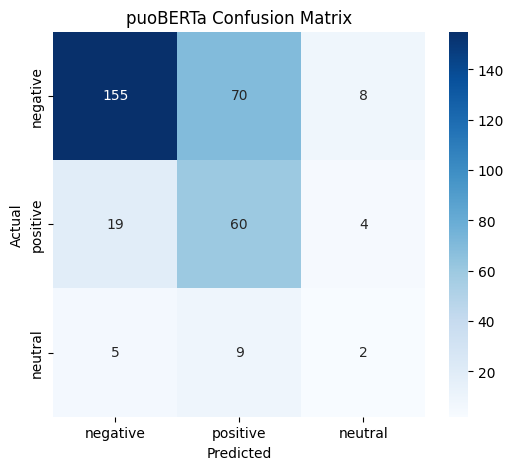

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
labels = ["negative", "positive", "neutral"]

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("puoBERTa Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
# Generate classification report
report = classification_report(y_true, y_pred, target_names=labels, output_dict=True)

# Extract F1 scores dynamically
f1_scores = [report[label]['f1-score'] for label in labels]

# Plot F1 scores
fig = px.bar(x=labels, y=f1_scores, labels={'x':'Class', 'y':'F1 Score'}, title="puoBERTa Per-Class F1 Scores", text=f1_scores)
fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig.update_layout(width=400, height=500)
fig.show()

**Final Results Comparison**

Afro-XLM-R vc BERT-base-uncased vc PuoBERTa

In [ ]:

# Create the data
data = {
    "Model": ["afro-xlmr-small", "bert-base-uncased", "puoberta"],
    "Macro-F1": [macro_f1_A, macro_f1_B, macro_f1_P],
    "Accuracy": [accuracy_A, accuracy_B, accuracy_P]
}

# Convert to DataFrame
df = pd.DataFrame(data)

#
df_melted = df.melt(id_vars="Model", var_name="Metric", value_name="Score")

# Create grouped bar chart
fig = px.bar(
    df_melted,
    x="Metric",
    y="Score",
    color="Model",
    barmode="group",
    text="Score",
    title="Model Macro-F1 vs Accuracy"
)

# Format layout
fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig.update_layout(
    yaxis=dict(title="Score", range=[0, 1]),
    xaxis_title="Metric",
    legend_title="Model"
    #template="plotly_white"
)
fig.update_layout(width=700, height=350)
fig.show()


In [ ]:
# Create data
data = {
    "Model": ["afro-xlmr-small", "bert-base-uncased", "puoberta"],
    "Precision": [Precision_A, Precision_B, Precision_P],
    "Recall": [Recall_A, Recall_B, Recall_P]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Melt into long format for grouped bar chart
df_melted = df.melt(id_vars="Model", var_name="Metric", value_name="Score")

# Create grouped bar chart
fig = px.bar(
    df_melted,
    x="Metric",
    y="Score",
    color="Model",
    barmode="group",
    text="Score",
    title="Model Precision and Recall"
)

# Customize layout and style
fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig.update_layout(
    yaxis=dict(title="Score", range=[0, 1]),
    xaxis_title="Metric",
    legend_title="Model"
)
fig.update_layout(width=700, height=350)
fig.show()


End